# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [44]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

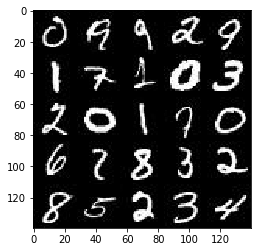

In [45]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

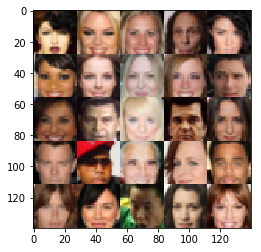

In [46]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [48]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [49]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1 # Leaky relu alpha
        
        # Input layer is 28x28x3
        resized_images=tf.image.resize_images(images, [32, 32])
        
        x1 = tf.layers.conv2d(resized_images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.2)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.1 # Leaky relu
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        result_img = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        result_img = tf.layers.dropout(result_img, rate=0.3)
        # 32x32x3
        
        logits=tf.image.resize_images(result_img, [28, 28])
        
        out = tf.tanh(logits) * 0.5
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1.0, 1.0, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #tf.reset_default_graph()
    out_channel_dim = data_shape[-1]

    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 50 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 0.6770... Generator Loss: 1.5948
Epoch 1/2... Discriminator Loss: 1.7452... Generator Loss: 0.3928


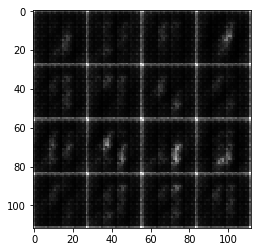

Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 1.1410
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 1.5519
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.9566
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.7407


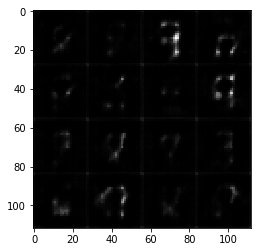

Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 1.2322
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6606


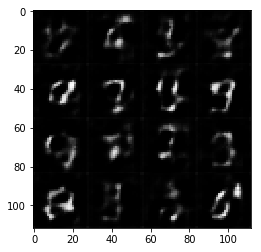

Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 1.0256
Epoch 1/2... Discriminator Loss: 1.5722... Generator Loss: 2.5609
Epoch 1/2... Discriminator Loss: 1.1007... Generator Loss: 0.8158
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.5126
Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 1.1855


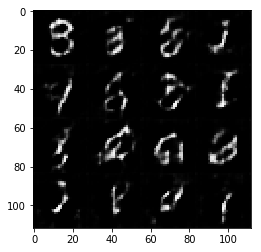

Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 1.9590
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 1.5720
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 1.5415
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.7053


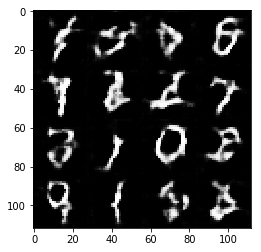

Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 1.0390
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 0.6099
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 1.1391
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.4747


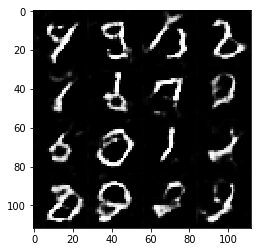

Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 0.8613
Epoch 1/2... Discriminator Loss: 1.2686... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.6629... Generator Loss: 0.4299
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 1.1095


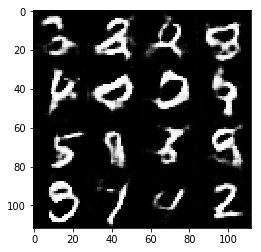

Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 1.0738
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.0846
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.8946
Epoch 1/2... Discriminator Loss: 1.2299... Generator Loss: 0.7775


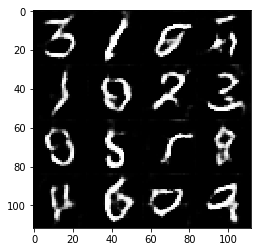

Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.1623... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 2.4128
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 1.1546


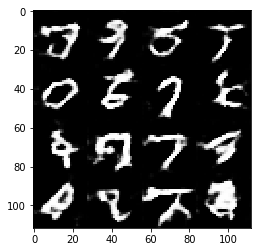

Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 1.2968
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.9402
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 1.4050
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.2276
Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 2.0215


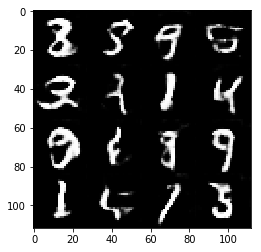

Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 1.0443
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 1.3239
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 1.7769
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 1.0674... Generator Loss: 1.0767


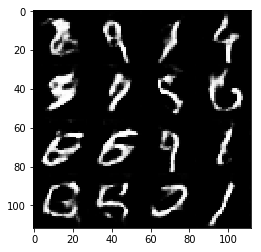

Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 1.5993
Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 1.6377
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 1.7465
Epoch 1/2... Discriminator Loss: 1.1647... Generator Loss: 0.7808
Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 1.0044


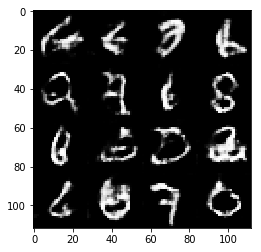

Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.6942
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.6049


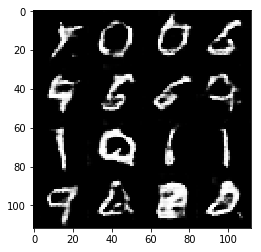

Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 1.5528
Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 1.1760
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.5931


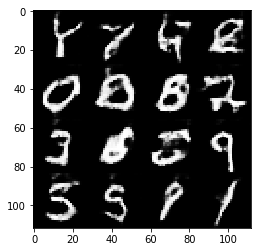

Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.4564
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.8776


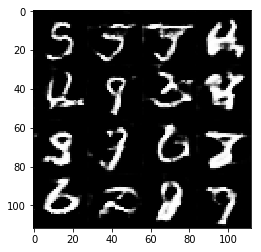

Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.6675
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 1.3856
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 1.5713
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 1.5264
Epoch 1/2... Discriminator Loss: 0.9706... Generator Loss: 1.1173


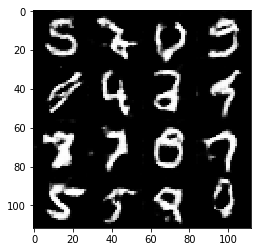

Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.2519
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 1.0549
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 1.0941
Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 1.8465
Epoch 1/2... Discriminator Loss: 1.6368... Generator Loss: 0.4236


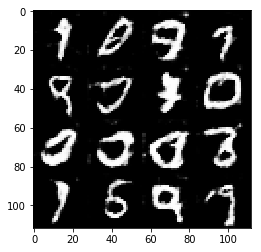

Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 1.4087
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 1.1373
Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 2.2087


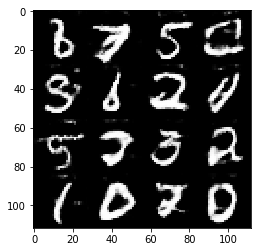

Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 1.0197
Epoch 1/2... Discriminator Loss: 1.2057... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 0.7410
Epoch 2/2... Discriminator Loss: 1.0356... Generator Loss: 1.0778


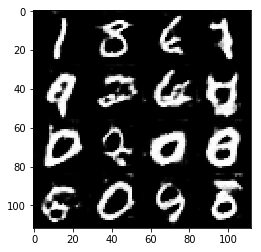

Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 1.4762
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.9648
Epoch 2/2... Discriminator Loss: 1.6797... Generator Loss: 2.3612


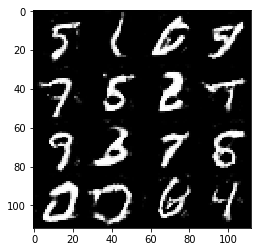

Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 1.1783
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 0.6802


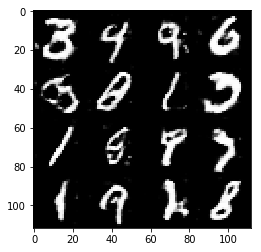

Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 1.5693
Epoch 2/2... Discriminator Loss: 1.9312... Generator Loss: 0.3122
Epoch 2/2... Discriminator Loss: 1.5117... Generator Loss: 0.4899
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.6679


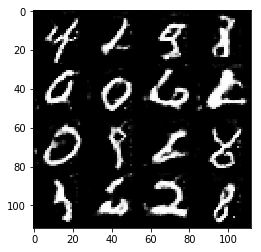

Epoch 2/2... Discriminator Loss: 1.0636... Generator Loss: 2.4249
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 2.4054
Epoch 2/2... Discriminator Loss: 1.5835... Generator Loss: 0.4207
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.0591
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.5923


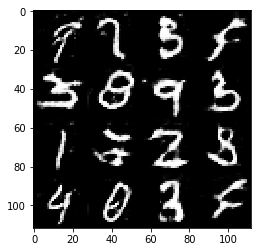

Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 1.2707
Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 1.4982
Epoch 2/2... Discriminator Loss: 0.8215... Generator Loss: 1.2168
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 0.9859


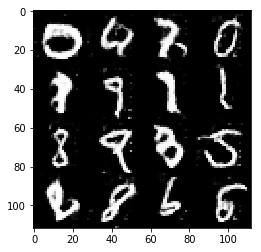

Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 1.1437
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.9818
Epoch 2/2... Discriminator Loss: 1.8640... Generator Loss: 3.4820
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 0.9951


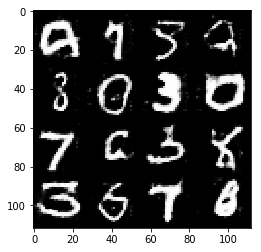

Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.0419
Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 1.7635
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.6765


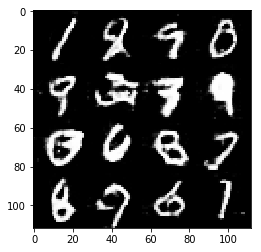

Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 2.2150
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 1.6283
Epoch 2/2... Discriminator Loss: 0.8939... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 0.9868
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 2.2419


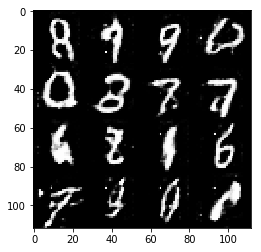

Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 2.4034
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 1.1576
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.1673
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.4791
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 1.4940


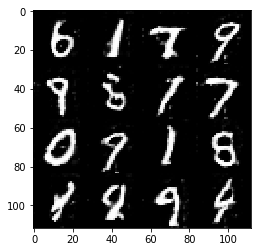

Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 0.6971


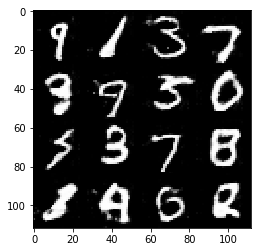

Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 1.4632
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 1.3161
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.4619
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.3765
Epoch 2/2... Discriminator Loss: 2.2958... Generator Loss: 3.6423


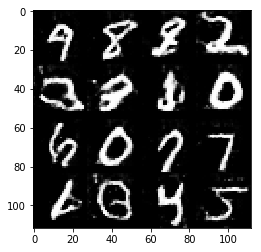

Epoch 2/2... Discriminator Loss: 1.7125... Generator Loss: 0.4029
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.1767
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 1.2989
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.1581
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.2983


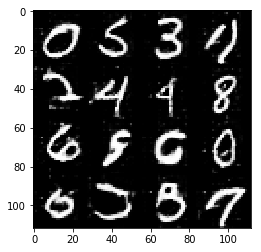

Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 1.7096
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.7001
Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 1.4325


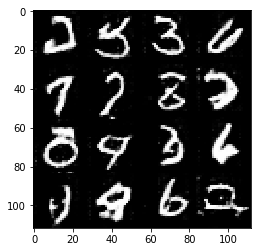

Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.1998
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 1.7341
Epoch 2/2... Discriminator Loss: 2.1158... Generator Loss: 0.2749
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 1.6319
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.2770


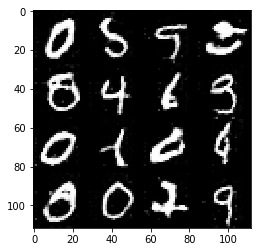

Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.5699... Generator Loss: 0.4804


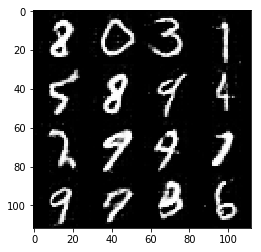

Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 1.0632
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 1.0056
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 2.1020


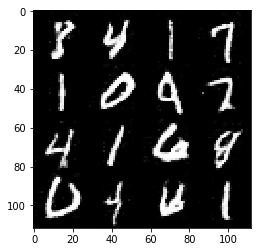

Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 0.8700... Generator Loss: 1.0966
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 1.3050
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.6302
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 0.8416


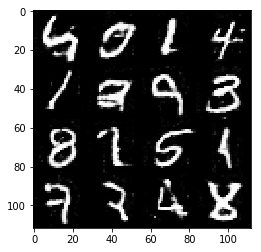

Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.2281
Epoch 2/2... Discriminator Loss: 1.4045... Generator Loss: 0.5537
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 1.1877


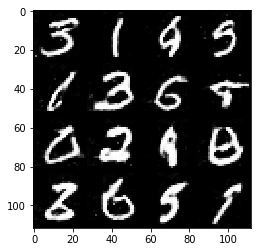

Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 1.0563
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.7932


In [55]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 15.0233
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.7039
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.9524
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7860


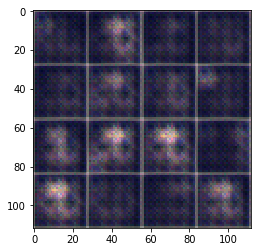

Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 1.3724
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8293


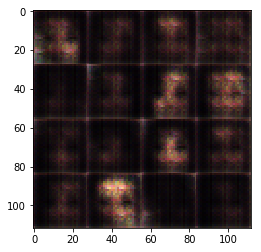

Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 2.0415... Generator Loss: 0.3298
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.8975


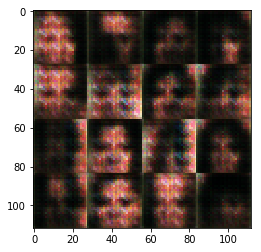

Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.1496


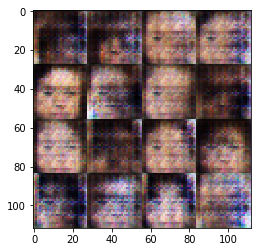

Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7847


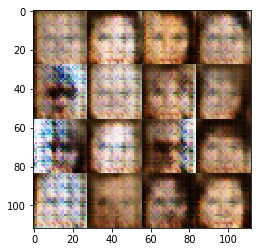

Epoch 1/1... Discriminator Loss: 1.8657... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 1.5909... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 1.9387
Epoch 1/1... Discriminator Loss: 1.7226... Generator Loss: 0.4294


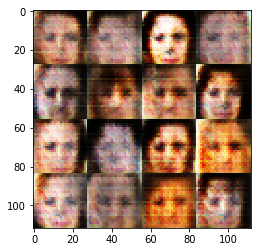

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.9434


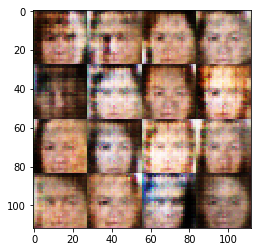

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.9933


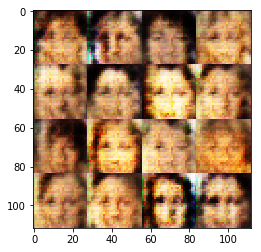

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.5648


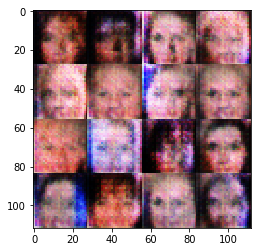

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 1.0098


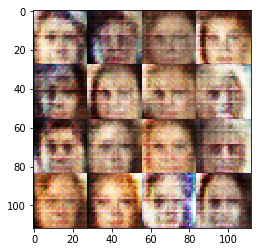

Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8955


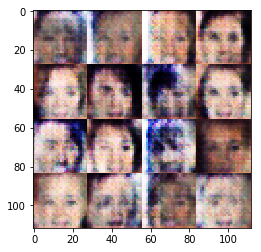

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 1.2056


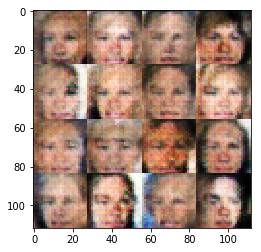

Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.1057


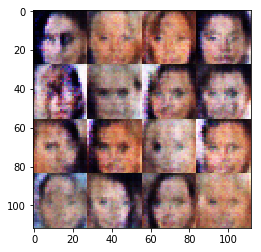

Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.7380... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 1.0498


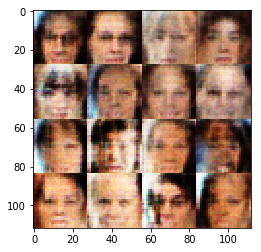

Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6682


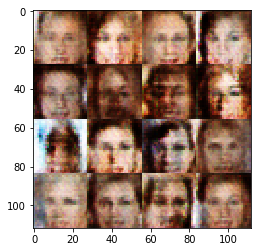

Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 1.0802


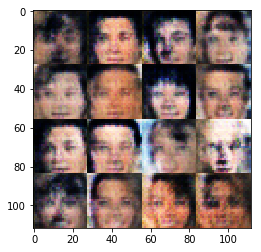

Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.6070


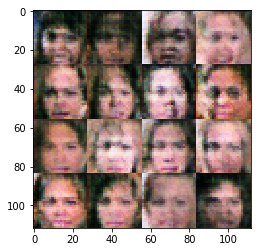

Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.8998


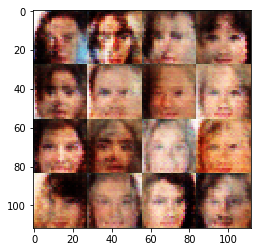

Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 1.1112


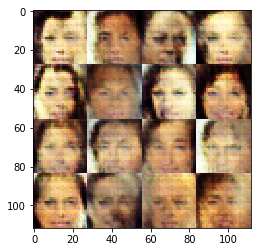

Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 1.2993
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 1.1392


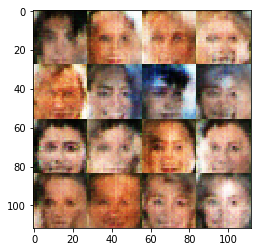

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.9156


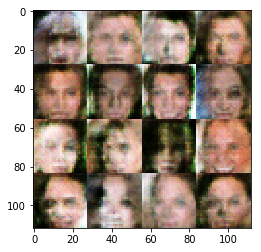

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.8669


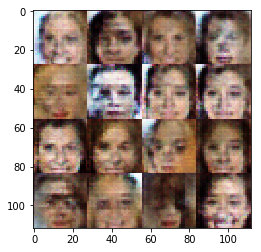

Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8975


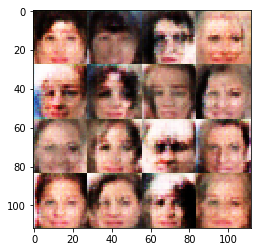

Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.6774


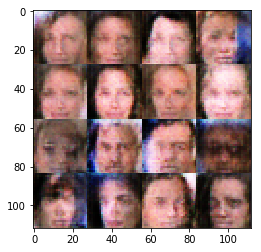

Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.8178


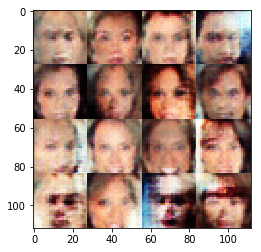

Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7616


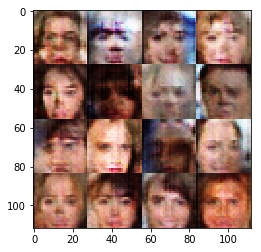

Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 1.1986
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.0046


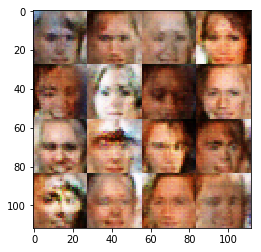

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 1.1207
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.9200


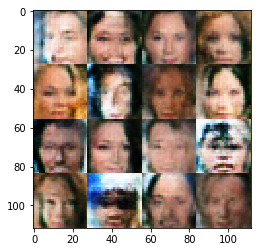

Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.7483


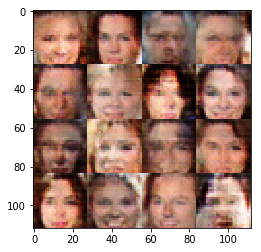

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.9050


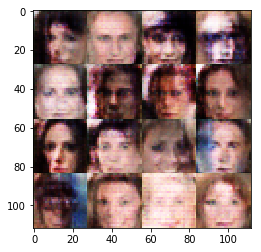

Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6627


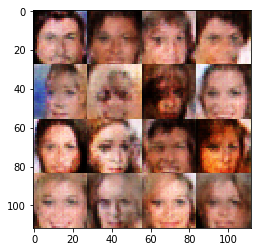

Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 1.1276


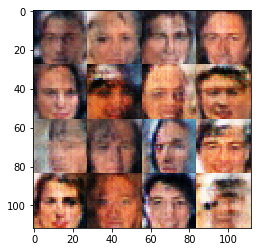

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7347


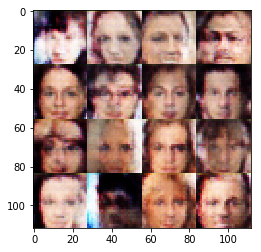

Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 1.0674


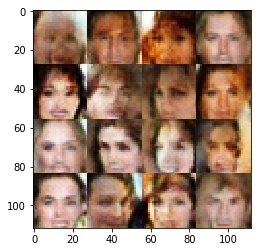

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8288


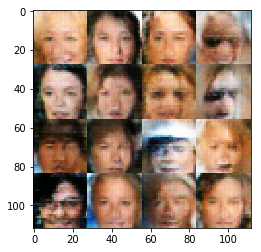

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.3505


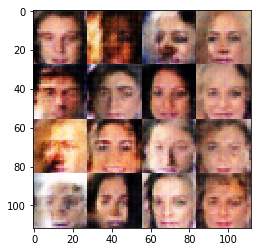

Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 1.1552
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6135


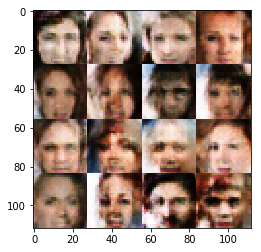

Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 1.0972


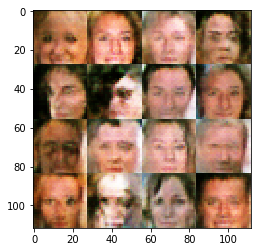

Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.6971


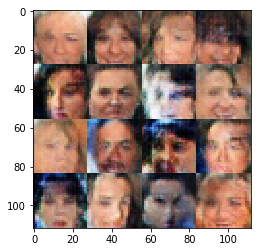

Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6743


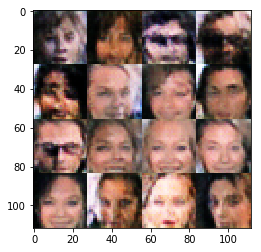

Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.9369


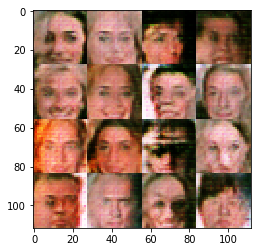

Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6806


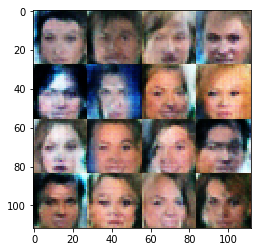

Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.3412
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.9078


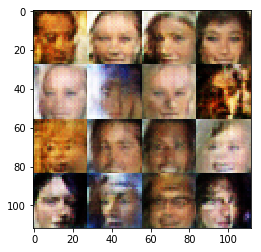

Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.9580


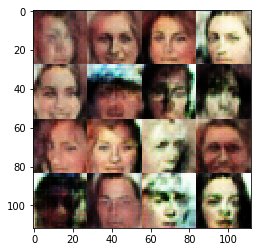

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6704


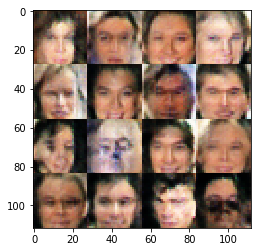

Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.7952


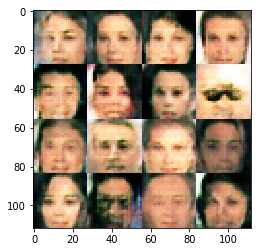

Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8031


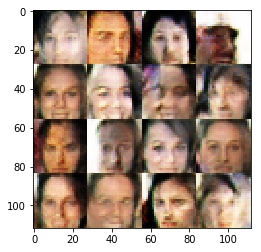

Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7773


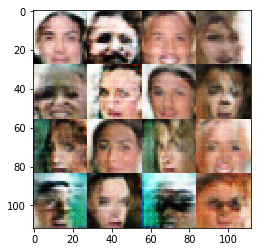

Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.8573


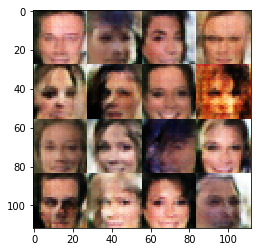

Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.9915


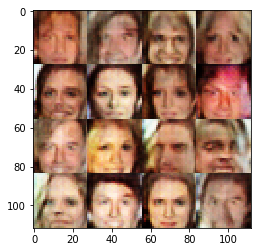

Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9580


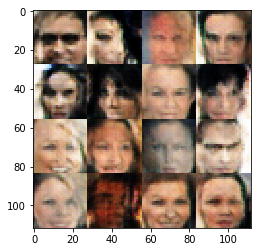

Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8368


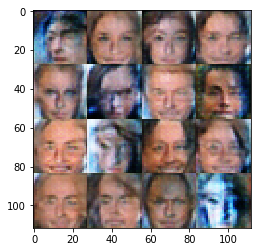

Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 1.7791
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7495


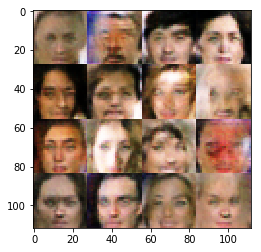

Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6409


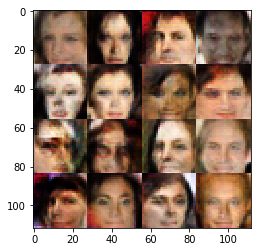

Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.9280


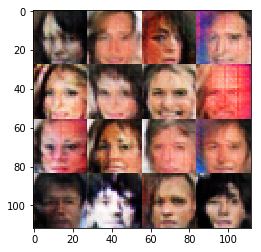

Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.8873


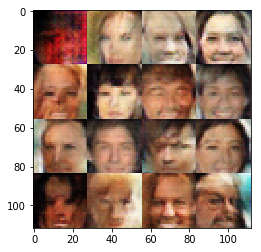

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.7629


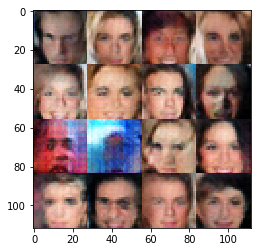

Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 1.1834
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5653


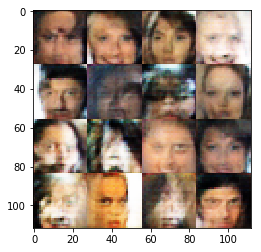

Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.8359


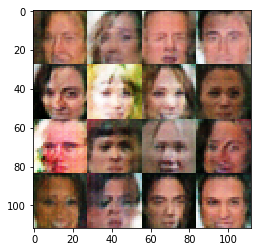

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7154


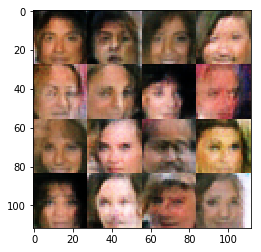

Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7967


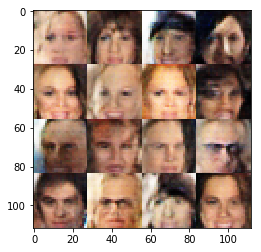

Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.6146


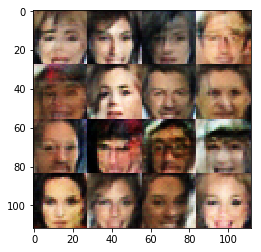

Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8181


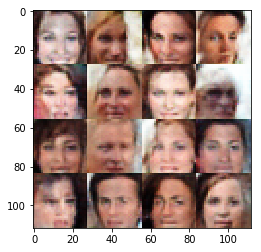

Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7939


In [56]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.